In [1]:
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import isomer_is_cis, isomer_is_fac, isomer_is_mer, isomer_is_trans
from polyhedral_analysis.configuration import Configuration

from pymatgen.core import Structure
from collections import Counter

from itertools import permutations
from tqdm import tqdm

from figure_formatting import figure_formatting as ff

ff.set_formatting()

colors = {'blue': '#264653',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [2]:
s = Structure.from_file('../Data/6x6x6_opt.vasp')

In [3]:
recipe = PolyhedraRecipe(method='distance cutoff',
                         coordination_cutoff=3.0,
                         central_atoms='Ti',
                         vertex_atoms=['O', 'F'])

In [4]:
c = Configuration(structure=s, recipes=[recipe])

In [5]:
dist = Counter([p.vertex_count['F'] for p in c.polyhedra])
dist

Counter({4: 194, 5: 11, 3: 11})

In [6]:
from scipy.stats import binom
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
f1 = [p for p in c.polyhedra if p.vertex_count['F'] == 1]
f0 = [p for p in c.polyhedra if p.vertex_count['F'] == 0]
f2 = [p for p in c.polyhedra if p.vertex_count['F'] == 2]
f3 = [p for p in c.polyhedra if p.vertex_count['F'] == 3]
f4 = [p for p in c.polyhedra if p.vertex_count['F'] == 4]
f5 = [p for p in c.polyhedra if p.vertex_count['F'] == 5]
f6 = [p for p in c.polyhedra if p.vertex_count['F'] == 6]

In [8]:
n_F2_trans = sum([isomer_is_trans(p, check=False) for p in f2])
n_F3_mer = sum([isomer_is_mer(p, check=False) for p in f3])
n_F4_trans = sum([isomer_is_trans(p, check=False) for p in f4])

In [9]:
print(f'[{len(f0)}] [{len(f1)}] [{n_F2_trans} {len(f2)-n_F2_trans}] [{n_F3_mer} {len(f3)-n_F3_mer}] [{n_F4_trans} {len(f4)-n_F4_trans}] [{len(f5)}] [{len(f6)}]')

[0] [0] [0 0] [0 11] [0 194] [11] [0]


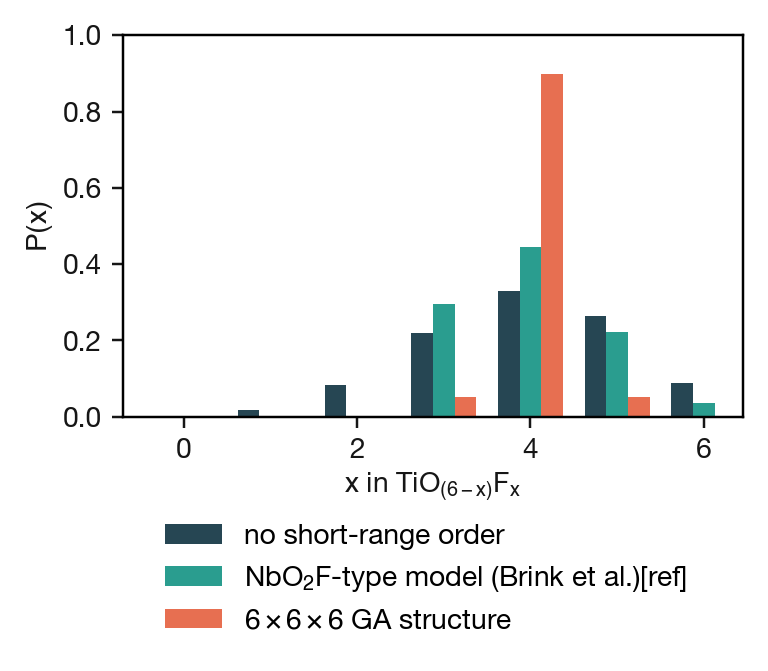

In [10]:
n = 6
p = 2/3
x = np.arange(0,7)
# probabilities of TiO1-xFx coordination for the Brink model → see Brink et al. J. Sol. Stat. Chem 2002.
brink = np.array([[0,1,2,3,4,5,6],
                  [0.0, 0.0, 0.0, 8/27, 12/27, 6/27, 1/27]]) 
dist_array = np.array(sorted([(k, v) for k, v in dist.items()])).T

width = 1/4
# plot.bar(r1, a1, width=width1)
plt.bar(x-width, binom.pmf(x, n, p), label='no short-range order', width=width, color=colors['blue'])
plt.bar(brink[0], brink[1], label=r'NbO$_2$F-type model (Brink et al.)[ref]', width=width, color=colors['green'])
plt.bar(dist_array[0]+width, dist_array[1]/sum(dist_array[1]), label=r'$6\times6\times6$ GA structure', width=width, color=colors['dark orange'])

plt.legend(loc=(0.05,-0.6))
plt.xlabel(r'$x$ in TiO$_{(6-x)}$F$_x$')
plt.ylabel(r'$P(x)$')
plt.ylim(0,1)
# plt.tight_layout()
plt.savefig('../Figures/6x6x6_octahedra_vs_Brink.pdf')
plt.show()

In [11]:
O_sites = [site for site in s if site.species_string == 'O']
mapped_O_coords = np.round(np.array([site.frac_coords for site in O_sites])*12).astype(int)
mapped_O_coords

array([[ 0,  0,  3],
       [ 0,  0,  7],
       [ 0,  0, 11],
       [ 0,  2,  3],
       [ 0,  2, 11],
       [ 0,  4,  3],
       [ 0,  4, 11],
       [ 0,  8,  3],
       [ 0,  8,  7],
       [ 0, 10,  3],
       [ 0, 10,  9],
       [ 2,  0,  1],
       [ 2,  0,  7],
       [ 2,  2,  1],
       [ 2,  2,  7],
       [ 2,  4,  3],
       [ 2,  4, 11],
       [ 2,  6,  3],
       [ 2,  6,  7],
       [ 2,  6, 11],
       [ 2,  8,  3],
       [ 2,  8,  7],
       [ 2,  8, 11],
       [ 2, 10,  1],
       [ 2, 10,  5],
       [ 4,  0,  9],
       [ 4,  2,  9],
       [ 4,  4,  9],
       [ 4,  6,  3],
       [ 4,  6,  9],
       [ 4,  8,  1],
       [ 4,  8,  5],
       [ 4,  8,  9],
       [ 4, 10,  3],
       [ 4, 10,  9],
       [ 6,  0,  3],
       [ 6,  0,  7],
       [ 6,  0, 11],
       [ 6,  2,  1],
       [ 6,  2,  7],
       [ 6,  4,  7],
       [ 6,  4, 11],
       [ 6,  6,  1],
       [ 6,  6,  9],
       [ 6,  8,  3],
       [ 6,  8,  7],
       [ 6,  8, 11],
       [ 6, 1

In [12]:
def sequence_from_column(column):
    for i in range(6):
        c = ''.join(np.roll(column, shift=i).astype(str))
        match c:
            case '000000':
                return 'FFFFFF' # 6
            case '100000':
                return 'OFFFFF' # 5
            case '110000':
                return 'OOFFFF' # 4
            case '101000':
                return 'OFOFFF' # 3,1
            case '100100':
                return 'OFFOFF' # 2,2
            case '111000':
                return 'OOOFFF' # 3
            case '110100':
                return 'OOFOFF' # 2,1
            case '110010':
                return 'OOFOFF' # also 2,1 under reflection
            case '101010':
                return 'OFOFOF' # 1,1,1
            case '111100':
                return 'OOOOFF' # 2
            case '111010':
                return 'OOOFOF' # 1,1
            case '110110':
                return 'OOFOOF' # alternate 1,1
            case '111110':
                return 'OOOOOF' # 1
            case '111111':
                return 'OOOOOO' # 0
    raise ValueError(column, c)

In [13]:
def columns_from_coords(mapped_O_coords: np.ndarray) -> Counter:
    
    seq = Counter()
    
    # loop over columns along z
    for x in [0, 2, 4, 6, 8, 10]:
        for y in [0, 2, 4, 6, 8, 10]:
            locs = np.where((mapped_O_coords[:,0] == x) & (mapped_O_coords[:,1] == y))[0]
            column = np.zeros(6, dtype=int)
            column[(mapped_O_coords[locs][:,2]-1)//2] = 1
            seq[sequence_from_column(column)] += 1

    # loop over columns along y
    for x in [0, 2, 4, 6, 8, 10]:
        for z in [0, 2, 4, 6, 8, 10]:
            locs = np.where((mapped_O_coords[:,0] == x) & (mapped_O_coords[:,2] == z))[0]
            column = np.zeros(6, dtype=int)
            column[(mapped_O_coords[locs][:,1]-1)//2] = 1
            seq[sequence_from_column(column)] += 1

    # loop over columns along x
    for y in [0, 2, 4, 6, 8, 10]:
        for z in [0, 2, 4, 6, 8, 10]:
            locs = np.where((mapped_O_coords[:,1] == y) & (mapped_O_coords[:,2] == z))[0]
            column = np.zeros(6, dtype=int)
            column[(mapped_O_coords[locs][:,0]-1)//2] = 1
            seq[sequence_from_column(column)] += 1
            
    return seq

In [14]:
m_seq = columns_from_coords(mapped_O_coords)
m_seq

Counter({'OFOFOF': 24, 'OFOFFF': 37, 'FFFFFF': 2, 'OFFOFF': 25, 'OFFFFF': 20})

In [15]:
sum(m_seq.values())

108

In [16]:
# What do these column counts look like for maximally disordered O/F?

In [17]:
anion_sites = [site for site in s if site.species_string in ['O', 'F']]

In [18]:
anion_sites

[PeriodicSite: O (0.0, 0.0, 5.697) [0.0, 0.0, 0.25],
 PeriodicSite: O (0.0, 0.0, 13.29) [0.0, 0.0, 0.5833],
 PeriodicSite: O (0.0, 0.0, 20.89) [0.0, 0.0, 0.9167],
 PeriodicSite: O (0.0, 3.798, 5.697) [0.0, 0.1667, 0.25],
 PeriodicSite: O (0.0, 3.798, 20.89) [0.0, 0.1667, 0.9167],
 PeriodicSite: O (0.0, 7.596, 5.697) [0.0, 0.3333, 0.25],
 PeriodicSite: O (0.0, 7.596, 20.89) [0.0, 0.3333, 0.9167],
 PeriodicSite: O (0.0, 15.19, 5.697) [0.0, 0.6667, 0.25],
 PeriodicSite: O (0.0, 15.19, 13.29) [0.0, 0.6667, 0.5833],
 PeriodicSite: O (0.0, 18.99, 5.697) [0.0, 0.8333, 0.25],
 PeriodicSite: O (0.0, 18.99, 17.09) [0.0, 0.8333, 0.75],
 PeriodicSite: O (3.798, 0.0, 1.899) [0.1667, 0.0, 0.08333],
 PeriodicSite: O (3.798, 0.0, 13.29) [0.1667, 0.0, 0.5833],
 PeriodicSite: O (3.798, 3.798, 1.899) [0.1667, 0.1667, 0.08333],
 PeriodicSite: O (3.798, 3.798, 13.29) [0.1667, 0.1667, 0.5833],
 PeriodicSite: O (3.798, 7.596, 5.697) [0.1667, 0.3333, 0.25],
 PeriodicSite: O (3.798, 7.596, 20.89) [0.1667, 0.33

In [19]:
count = Counter()
for j in range(1):
    for i in tqdm(range(100000)):
        random_O_sites = np.random.choice(a=anion_sites, size=len(anion_sites)//3, replace=False)
        mapped_O_coords = np.round(np.array([site.frac_coords for site in random_O_sites])*12).astype(int)
        seq = columns_from_coords(mapped_O_coords)
        count.update(seq)
    print(count)

100%|██████████████████████████████████████████████████████████████████| 100000/100000 [07:35<00:00, 219.33it/s]

Counter({'OFFFFF': 2842643, 'OFOFFF': 1430860, 'OOFFFF': 1427935, 'OOFOFF': 1427143, 'FFFFFF': 937657, 'OFFOFF': 714963, 'OOOFFF': 711630, 'OOOOFF': 353049, 'OOOFOF': 352959, 'OFOFOF': 236847, 'OOFOOF': 176697, 'OOOOOF': 173541, 'OOOOOO': 14076})


In [20]:
all_columns = ['FFFFFF',
               'OFFFFF',
               'OOFFFF',
               'OFOFFF',
               'OFFOFF',
               'OOOFFF',
               'OOFOFF',
               'OFOFOF',
               'OOOFOF',
               'OOOOFF',
               'OOFOOF',
               'OOOOOF',
               'OOOOOO']

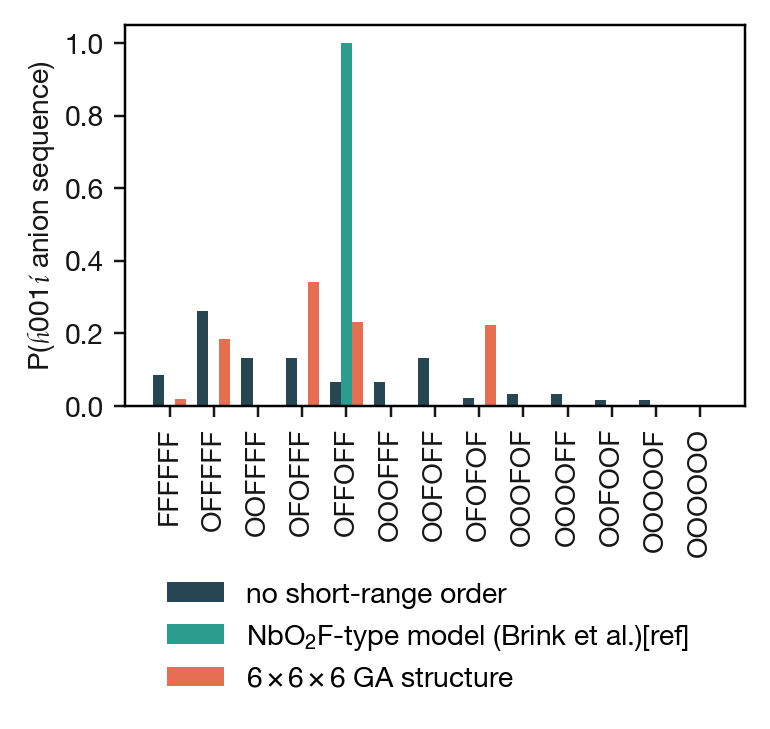

In [21]:
width = 1/4
x = np.arange(len(all_columns))
p_seq = [count[k]/sum(count.values()) for k in all_columns]
p_m_seq = [m_seq[k]/sum(m_seq.values()) for k in all_columns]
plt.bar(x-width, p_seq, width=width, color=colors['blue'], label='no short-range order')
plt.bar(all_columns.index('OFFOFF'), 1, width=width, color=colors['green'], label=r'NbO$_2$F-type model (Brink et al.)[ref]')
plt.bar(x+width, p_m_seq, width=width, color=colors['dark orange'], label=r'$6\times6\times6$ GA structure')
plt.legend(loc=(0.05,-0.78))
plt.xticks(x, all_columns, rotation='vertical')
plt.ylabel(r'$P$($\left<001\right>$ anion sequence)')
# plt.tight_layout()
plt.savefig('../Figures/6x6x6_columns_vs_Brink.pdf')
plt.show()


In [22]:
count['OFFOFF']/sum(count.values())

0.06620027777777777